In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# loading clean data

In [2]:
import os
clean_files = ['../data/cleaned_data/all_dataset.parquet']

In [3]:
dfs = []
for file in clean_files:
    dfs.append(pd.read_parquet(file))
df = pd.concat(dfs, axis = 0)

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df['state_of_charge_percent'] = df['state_of_charge_percent'].clip(0,140)

In [6]:
min_soc = 0
max_soc = 140
step = 20
df['binned_soc'] = pd.cut(df['state_of_charge_percent'], bins = np.arange(min_soc, max_soc+step,step))

In [7]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [8]:
df.columns

Index(['battery_id', 'battery_voltage', 'current', 'current_in', 'current_out',
       'panel_voltage', 'state_of_charge_percent', 'temperature',
       'usb_current', 'voltage', 'power_out', 'usb_power', 'power_in',
       'net_power_battery', 'other_out_current', 'bool_current_out',
       'bool_current_in', 'hour', 'minutes', 'day_n', 'hour:min',
       'binned_soc'],
      dtype='object')

In [9]:
features = df.groupby(['battery_id','binned_soc'])[['other_out_current','temperature','usb_power']].agg(['median',percentile(1),percentile(99)])

In [10]:
features[[('count','count')]] = df.groupby(['battery_id','binned_soc'])[['power_out']].agg(['count'])

<AxesSubplot:xlabel='binned_soc'>

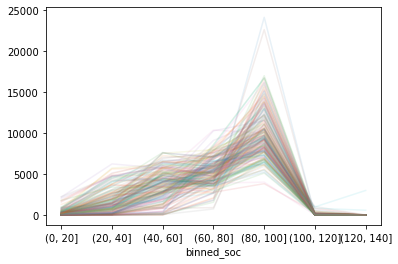

In [11]:
features['count'].unstack(level = 0).plot(y = 'count', alpha = 0.1, legend = False)

<AxesSubplot:xlabel='binned_soc'>

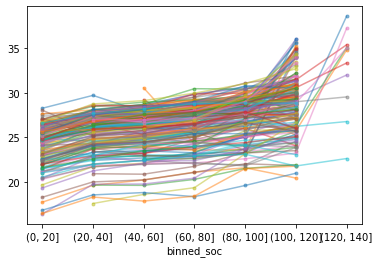

In [12]:
features[('temperature','median')].unstack(level = 0).plot(alpha = 0.5, legend = False, marker = '.')

# PCA

In [13]:
features = features.groupby('binned_soc').apply(lambda x: x.fillna(x.mean()))

In [14]:
features = features.unstack(level = 1)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = S  tandardScaler()
X_std = scaler.fit_transform(features)

C:\Users\PC_victor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\PC_victor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


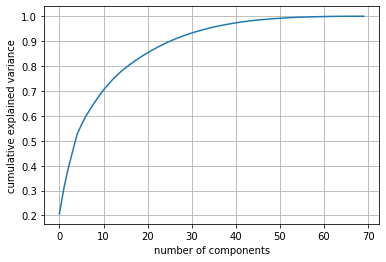

In [16]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_std)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.grid();

In [17]:
n_components = 10
two_comp_PCA = PCA(n_components=n_components)
X_pca = two_comp_PCA.fit_transform(X_std)

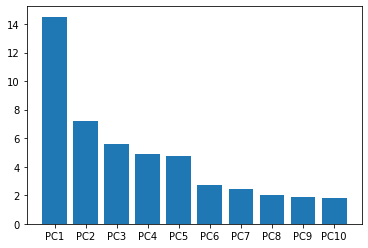

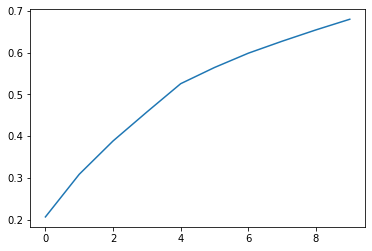

In [18]:
plt.bar(x = [f'PC{k}' for k in range(1,n_components+1)], height = two_comp_PCA.explained_variance_)
plt.figure()
plt.plot(np.cumsum(two_comp_PCA.explained_variance_ratio_))

In [19]:
loadings = two_comp_PCA.components_.T * np.sqrt(two_comp_PCA.explained_variance_)


In [20]:
feature_names = features.columns.map('{0[0]}_{0[1]}_{0[2]}'.format) 

In [21]:
df_loadings = pd.DataFrame(data = loadings, index = feature_names)

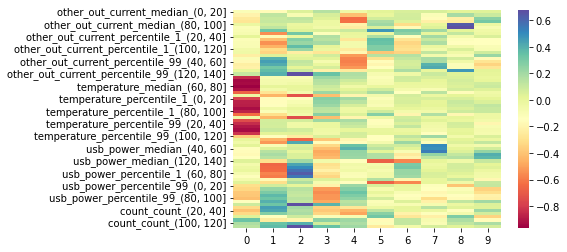

In [22]:
ax = sns.heatmap(df_loadings, annot=False, cmap='Spectral')
plt.show()

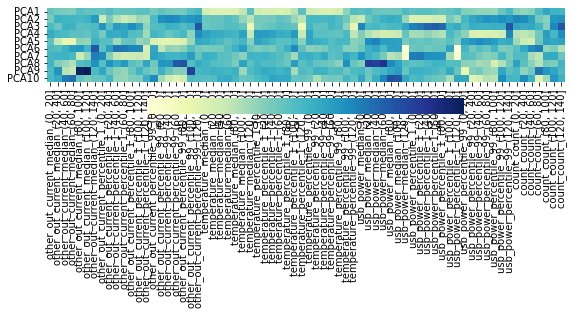

In [23]:
plt.figure(figsize = (10,4))
ax = sns.heatmap(two_comp_PCA.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,two_comp_PCA.n_components_+1)],
                 xticklabels=list(feature_names),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.tight_layout()

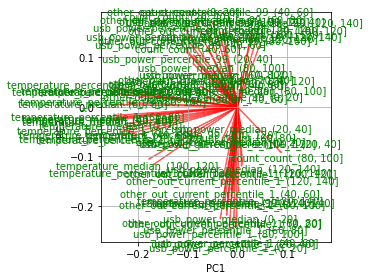

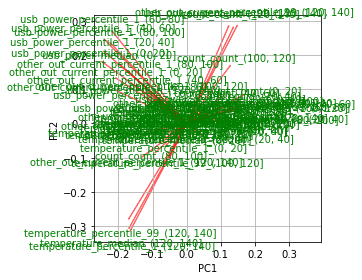

In [24]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    #plt.scatter(xs * scalex,ys * scaley, c = ys)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.axis('square')
    plt.grid()
    plt.tight_layout()

#Call the function. Use only the 2 PCs.
myplot(X_pca[:,0:2],np.transpose(two_comp_PCA.components_[0:2, :]), labels=feature_names)
plt.show()

plt.figure()
myplot(X_pca[:,1:3],np.transpose(two_comp_PCA.components_[1:3, :]), labels=feature_names)
plt.show()

In [25]:
most_important = [np.abs(two_comp_PCA.components_[i]).argmax() for i in range(n_components)]

initial_feature_names = feature_names
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_components)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_components)}

# build the dataframe
df_most_imp = pd.DataFrame(dic.items())

df_most_imp

,0,1
0,PC0,"temperature_median_(60, 80]"
1,PC1,"usb_power_percentile_1_(0, 20]"
2,PC2,"temperature_percentile_1_(120, 140]"
3,PC3,"usb_power_percentile_99_(40, 60]"
4,PC4,"other_out_current_median_(40, 60]"
5,PC5,"usb_power_median_(120, 140]"
6,PC6,"usb_power_median_(120, 140]"
7,PC7,"usb_power_median_(60, 80]"
8,PC8,"other_out_current_median_(100, 120]"
9,PC9,"usb_power_median_(80, 100]"


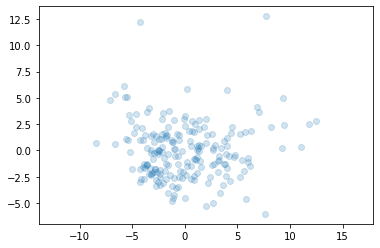

In [26]:
# plot data
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
plt.axis('equal');

# clustering

In [27]:
n_components_to_keep = 5
X_clustering = X_pca[:,:n_components_to_keep]

In [28]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_clustering)
    distortions.append(kmeanModel.inertia_)

C:\Users\PC_victor\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


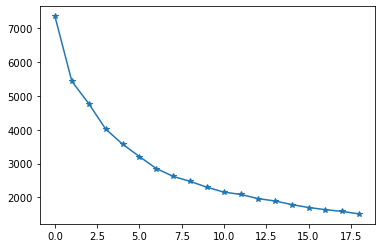

In [29]:
plt.plot(distortions, marker = "*")

can choose 6 as a start

In [30]:
n_clusters = 6
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
kmeanModel = KMeans(n_clusters=n_clusters)
y=kmeanModel.fit(X_clustering).labels_
y_bin = label_binarize(y, classes=np.arange(0,n_clusters))
clf=RandomForestClassifier()
clf.fit(X_clustering,y)

RandomForestClassifier()

(array([49.,  0., 41.,  0., 69.,  0.,  1.,  0., 25., 15.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

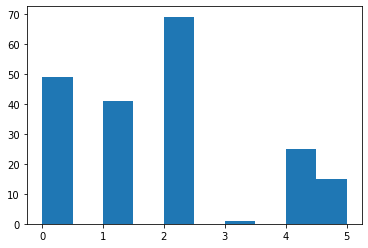

In [31]:
plt.hist(y, bins = 10)

In [32]:
import shap
explainer= shap.TreeExplainer(clf)
shap_values = explainer(X_clustering)

plot 0


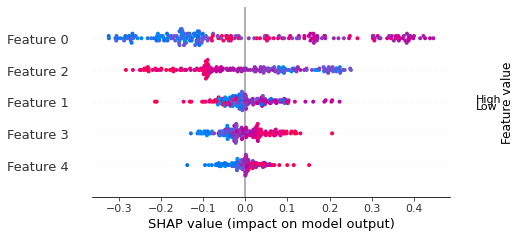

plot 1


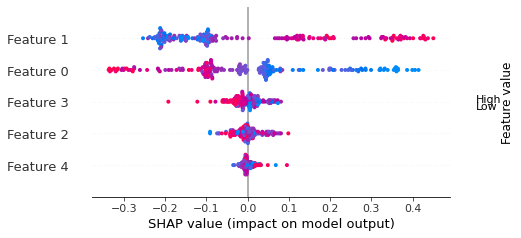

plot 2


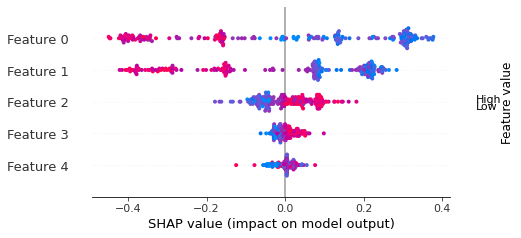

plot 3


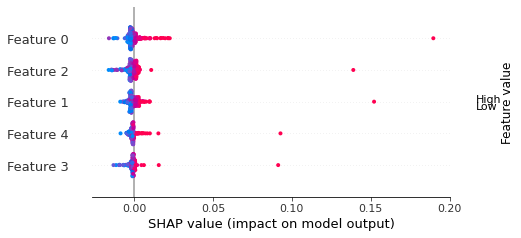

plot 4


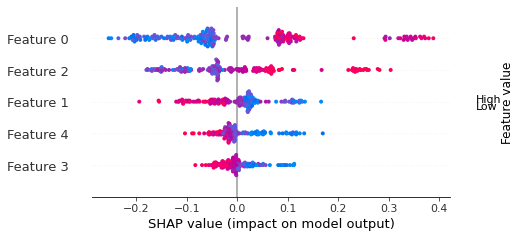

plot 5


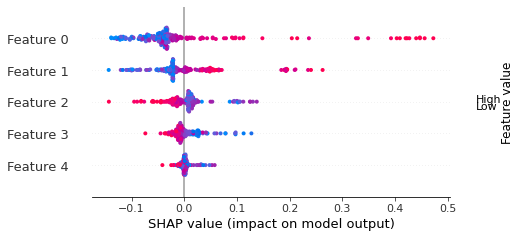

In [33]:
for k in range(n_clusters):
    print(f'plot {k}')
    shap.plots.beeswarm(shap_values[:,:,k])


In [34]:
df_X_clsutering = pd.DataFrame(data= X_clustering, index = features.index, columns = [f'PC{k}' for k in range(1,n_components_to_keep+1)])
df_y_clustering = pd.DataFrame(data= y, index = features.index, columns = ['class'])

In [103]:
features.head()

other_out_current                                                  \
                      median                                                   
binned_soc           (0, 20] (20, 40] (40, 60] (60, 80] (80, 100] (100, 120]   
battery_id                                                                     
0                      0.002    0.010    0.392    0.392     0.010      0.006   
1                      0.002    0.200    0.198    0.194     0.176      0.002   
2                      0.006    0.204    0.198    0.192     0.006      0.188   
3                      0.004    0.200    0.198    0.198     0.178      0.150   
4                      0.002    0.188    0.374    0.370     0.168      0.016   

                                                      ...     usb_power  \
                      percentile_1                    ... percentile_99   
binned_soc (120, 140]      (0, 20] (20, 40] (40, 60]  ...     (80, 100]   
battery_id                                            ...                 
0            0.009455      0.00000    0.002  0.00400  ...      2.439726   
1            0.009455      0.00000    0.000  0.00400  ...      3.028923   
2            0.009455      0.00000    0.002  0.00852  ...      3.873574   
3            0.009455      0.00200    0.002  0.00200  ...      4.932230   
4            0.009455      0.00098    0.002  0.00600  ...      4.997390   

                                   count                                       \
                                   count                                        
binned_soc (100, 120] (120, 140] (0, 20] (20, 40] (40, 60] (60, 80] (80, 100]   
battery_id                                                                      
0            2.128545   0.836904      49     2615     3551     3485      6749   
1            3.058142   0.836904     214     1433     4072     7871     11309   
2            4.642866   0.836904     172      928     2627     4684     16137   
3            1.174736   0.836904    1601     4848     5760     4744      9363   
4            4.558297   0.836904     250     5129     6446     5911      8093   

                                  
                                  
binned_soc (100, 120] (120, 140]  
battery_id                        
0                 170          0  
1                 154          0  
2                   7          0  
3                  21          0  
4                  36          0  

[5 rows x 70 columns]

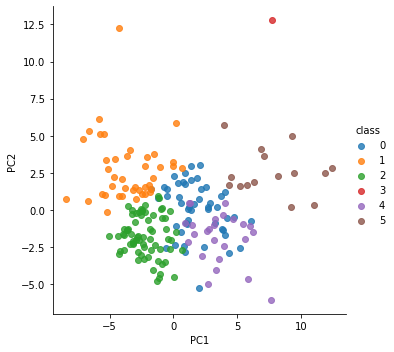

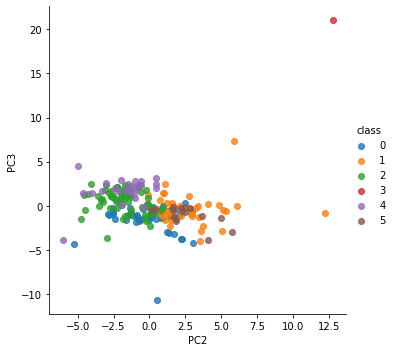

In [35]:
sns.lmplot(data = pd.concat([df_X_clsutering, df_y_clustering], axis = 1), x = 'PC1', y = 'PC2', hue = 'class', fit_reg = False)
sns.lmplot(data = pd.concat([df_X_clsutering, df_y_clustering], axis = 1), x = 'PC2', y = 'PC3', hue = 'class', fit_reg = False)

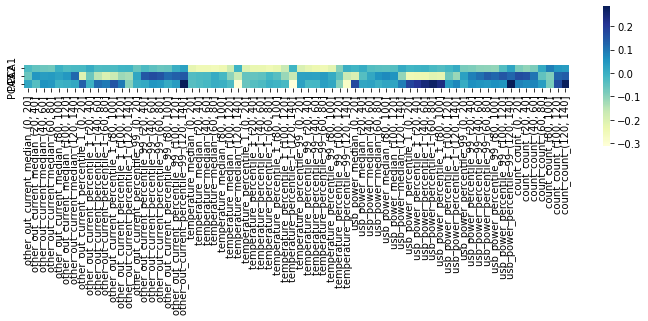

In [36]:
plt.figure(figsize = (10,4))
ax = sns.heatmap(two_comp_PCA.components_[:3],
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,3+1)],
                 xticklabels=list(feature_names),
                 cbar_kws={"orientation": "vertical"})
ax.set_aspect("equal")
plt.tight_layout()

# post clustering statistics

In [37]:
features_class = features.copy()
features_class.columns = feature_names

In [38]:
features_class = features_class.join(df_y_clustering, on = 'battery_id')

In [39]:
df_most_imp

,0,1
0,PC0,"temperature_median_(60, 80]"
1,PC1,"usb_power_percentile_1_(0, 20]"
2,PC2,"temperature_percentile_1_(120, 140]"
3,PC3,"usb_power_percentile_99_(40, 60]"
4,PC4,"other_out_current_median_(40, 60]"
5,PC5,"usb_power_median_(120, 140]"
6,PC6,"usb_power_median_(120, 140]"
7,PC7,"usb_power_median_(60, 80]"
8,PC8,"other_out_current_median_(100, 120]"
9,PC9,"usb_power_median_(80, 100]"


In [40]:
features_class = features_class.reset_index().set_index('class')

In [41]:
features_class = features_class.reset_index().set_index('battery_id')

In [50]:
features_class.groupby('class')[['temperature_median_(60, 80]']].median()

,"temperature_median_(60, 80]"
class,
0,25.643168
1,28.299382
2,27.743191
3,22.888533
4,24.316777
5,22.041657


In [100]:
print(features_class.groupby('class')[['usb_power_percentile_1_(40, 60]']].median())
print(features_class.groupby('class')[['usb_power_percentile_99_(40, 60]']].median())


       usb_power_percentile_1_(40, 60]
class                                 
0                             0.013030
1                             0.012981
2                             0.025940
3                             0.025256
4                             0.025960
5                             0.013000
       usb_power_percentile_99_(40, 60]
class                                  
0                              2.788693
1                              5.013626
2                              4.184384
3                              3.032166
4                              2.977308
5                              4.012042


# times series

In [62]:
profiles = df.groupby(['battery_id','hour','minutes']).median()

In [64]:
profiles = profiles.reset_index().set_index(['hour','minutes'])

In [81]:
profiles['class'] = profiles['battery_id'].map(df_y_clustering.squeeze().to_dict())

In [90]:
profiles = profiles.sort_index()
profiles = profiles.reset_index().set_index(['battery_id','hour','minutes'])

<AxesSubplot:xlabel='hour,minutes'>

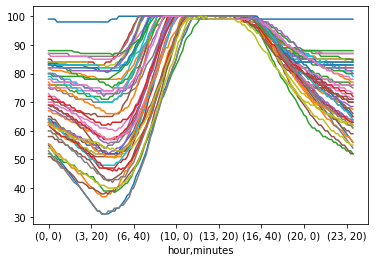

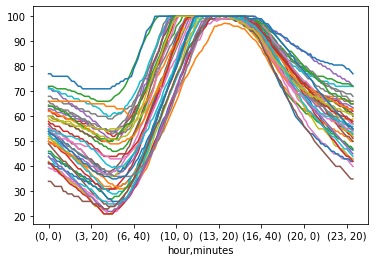

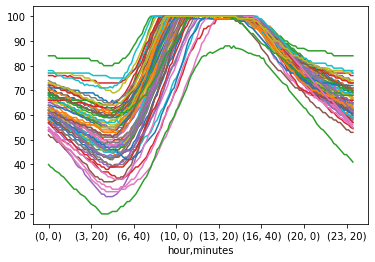

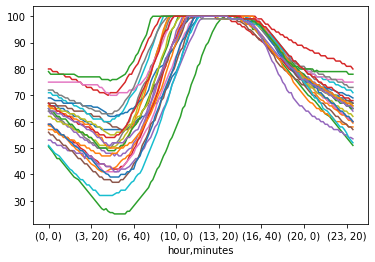

In [98]:
profiles[profiles['class'] == 0][['state_of_charge_percent']].unstack(level = 0).plot(legend = False)
profiles[profiles['class'] == 1][['state_of_charge_percent']].unstack(level = 0).plot(legend = False)
profiles[profiles['class'] == 2][['state_of_charge_percent']].unstack(level = 0).plot(legend = False)
profiles[profiles['class'] == 4][['state_of_charge_percent']].unstack(level = 0).plot(legend = False)

<AxesSubplot:xlabel='hour,minutes'>

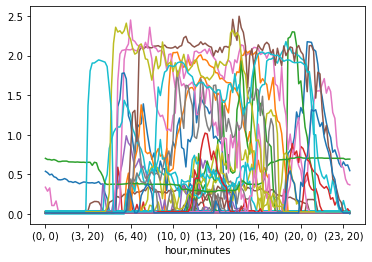

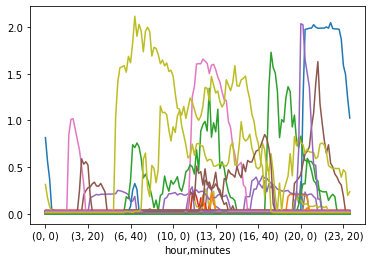

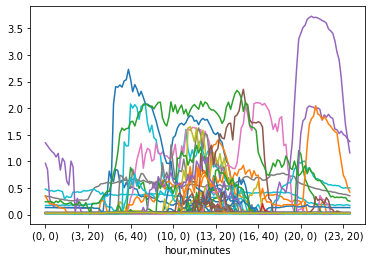

In [102]:
profiles[profiles['class'] == 1][['usb_power']].unstack(level = 0).plot(legend = False)
profiles[profiles['class'] == 0][['usb_power']].unstack(level = 0).plot(legend = False)
profiles[profiles['class'] == 2][['usb_power']].unstack(level = 0).plot(legend = False)

<AxesSubplot:xlabel='hour,minutes'>

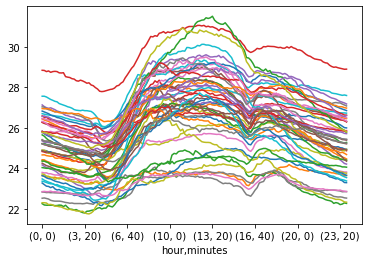

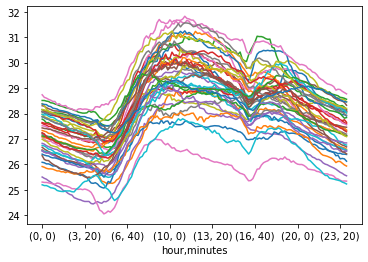

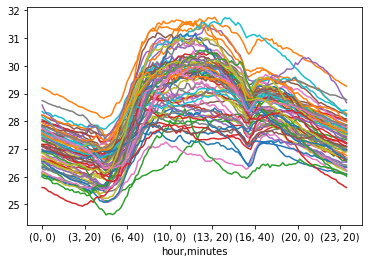

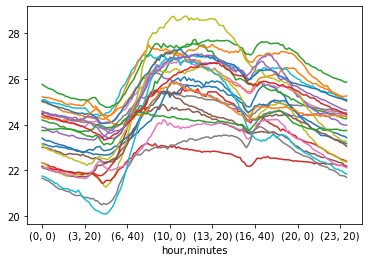

In [99]:
profiles[profiles['class'] == 0][['temperature']].unstack(level = 0).plot(legend = False)
profiles[profiles['class'] == 1][['temperature']].unstack(level = 0).plot(legend = False)
profiles[profiles['class'] == 2][['temperature']].unstack(level = 0).plot(legend = False)
profiles[profiles['class'] == 4][['temperature']].unstack(level = 0).plot(legend = False)

In [106]:
df.join()

,battery_id,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,usb_current,voltage,...,power_in,net_power_battery,other_out_current,bool_current_out,bool_current_in,hour,minutes,day_n,hour:min,binned_soc
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-03-02 06:40:00,0,7.0750,-2.276,2.278,0.002,7.350,100.0,28.287938,0.002,7.280,...,16.116850,16.102700,0.000,0.0,1.0,6,40,1,6:40,"(80, 100]"
2021-03-02 06:50:00,0,6.7200,0.000,0.002,0.002,0.005,102.0,27.152667,0.002,6.735,...,0.013440,0.000000,0.000,0.0,0.0,6,50,1,6:50,"(100, 120]"
2021-03-02 07:00:00,0,6.7100,0.010,0.002,0.012,0.005,102.0,26.919203,0.002,6.725,...,0.013420,-0.067100,0.010,0.0,0.0,7,0,1,7:0,"(100, 120]"
2021-03-02 07:10:00,0,6.7050,0.010,0.002,0.012,0.005,102.0,27.003891,0.002,6.720,...,0.013410,-0.067050,0.010,0.0,0.0,7,10,1,7:10,"(100, 120]"
2021-03-02 07:20:00,0,6.7025,0.013,0.002,0.015,0.005,102.0,27.096590,0.002,6.715,...,0.013405,-0.087125,0.013,0.0,0.0,7,20,1,7:20,"(100, 120]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-05 06:50:00,199,6.7150,-0.824,0.832,0.008,6.760,34.0,27.251087,0.002,6.780,...,5.586880,5.533160,0.006,0.0,1.0,6,50,0,6:50,"(20, 40]"
2021-07-05 07:00:00,199,6.7250,-0.906,0.914,0.008,6.780,35.0,27.386130,0.002,6.795,...,6.146650,6.092850,0.006,0.0,1.0,7,0,0,7:0,"(20, 40]"
2021-07-05 07:10:00,199,6.7300,-0.954,0.962,0.008,6.790,36.0,27.484550,0.000,6.800,...,6.474260,6.420420,0.008,0.0,1.0,7,10,0,7:10,"(20, 40]"


# Viz

<AxesSubplot:xlabel='day_n,hour,minutes'>

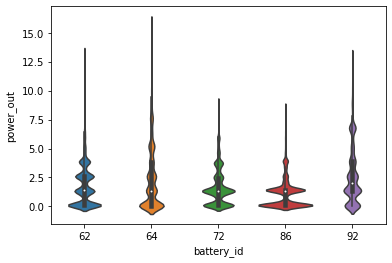

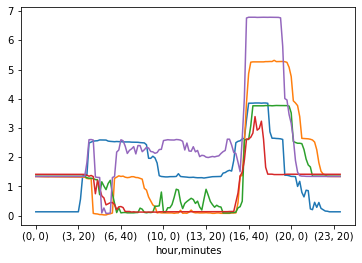

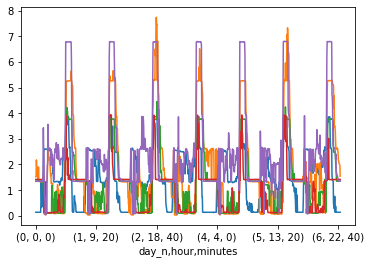

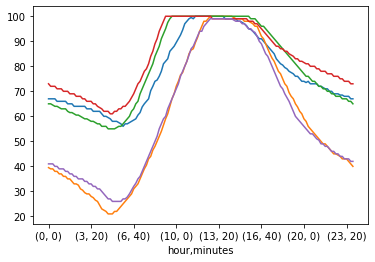

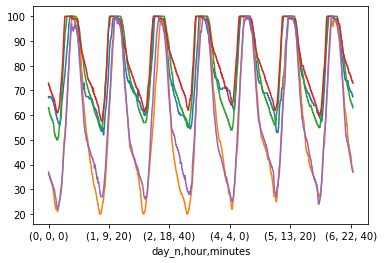

In [5]:
n = 5
randoms_ids = np.random.choice(df.battery_id.unique(), n)

subset = df[df['battery_id'].isin(randoms_ids)]

sns.violinplot(data = subset, x = 'battery_id', y="power_out")

weekly_median_profiles = subset.groupby(['battery_id','day_n','hour','minutes']).median()
daily_median_profiles = subset.groupby(['battery_id','hour','minutes']).median()

daily_median_profiles['power_out'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)
weekly_median_profiles['power_out'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

daily_median_profiles['state_of_charge_percent'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)
weekly_median_profiles['state_of_charge_percent'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

<AxesSubplot:xlabel='day_n,hour,minutes'>

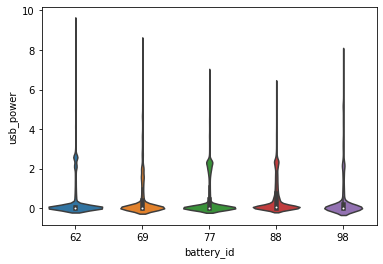

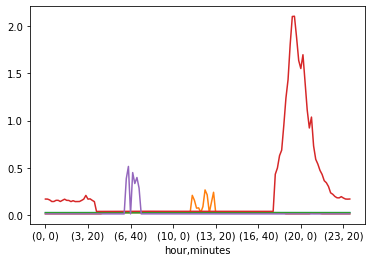

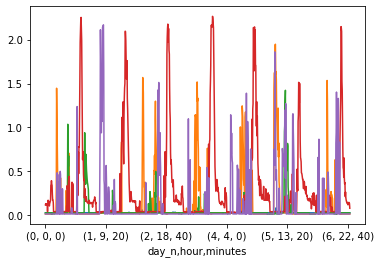

In [17]:
sns.violinplot(data = subset, x = 'battery_id', y="usb_power")

weekly_median_profiles = subset.groupby(['battery_id','day_n','hour','minutes']).median()
daily_median_profiles = subset.groupby(['battery_id','hour','minutes']).median()

daily_median_profiles['usb_power'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)
weekly_median_profiles['usb_power'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

<AxesSubplot:title={'center':'mean power_out per soc_bin'}, xlabel='binned_soc'>

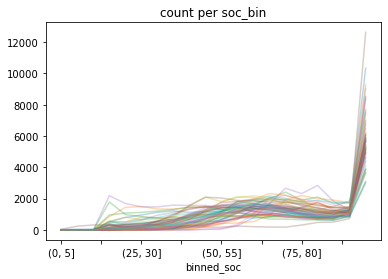

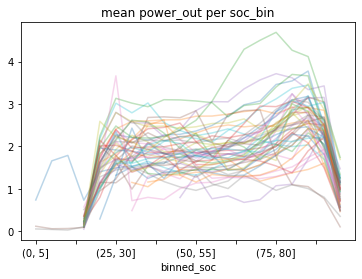

In [15]:
increment = 5
df['binned_soc'] = pd.cut(df['state_of_charge_percent'], np.arange(0,100+increment,increment))
count = df.groupby(['battery_id','binned_soc'])['state_of_charge_percent'].count()
binned_soc = df.groupby(['battery_id','binned_soc']).mean()
binned_soc['count'] = count

binned_soc['count'].unstack(level = 0).plot(legend = False, alpha = 0.3, title = 'count per soc_bin')
binned_soc['power_out'].unstack(level = 0).plot(legend = False, alpha = 0.3, title = 'mean power_out per soc_bin')

In [18]:
df = df.reset_index().set_index(['timestamp','battery_id'])
df = df.sort_index()

In [19]:
df['observed_mileage'] = df.groupby('battery_id')['power_out'].transform('cumsum')

<AxesSubplot:title={'center':'mileage (cumulative sum of output power)'}, xlabel='timestamp'>

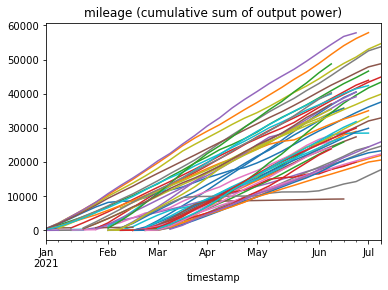

In [22]:
df['observed_mileage'].unstack(level = 1).resample('1W').mean().plot(legend = False, title = 'mileage (cumulative sum of output power)')

# little fun

In [26]:
print(df.index.min(), df.index.max())

2021-01-01 00:00:00 2021-07-10 04:40:00


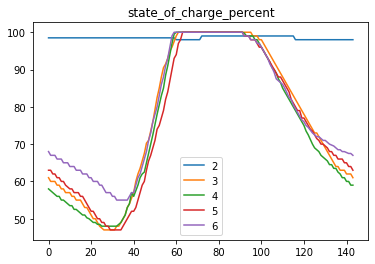

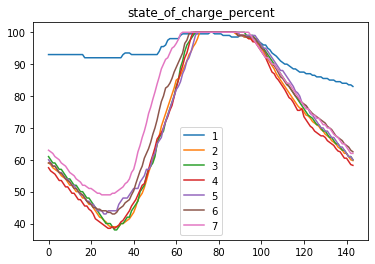

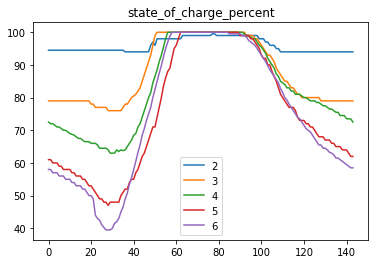

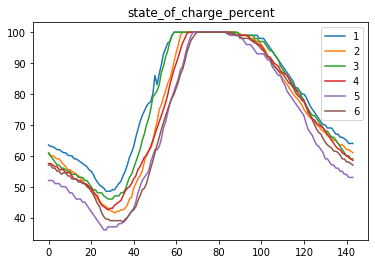

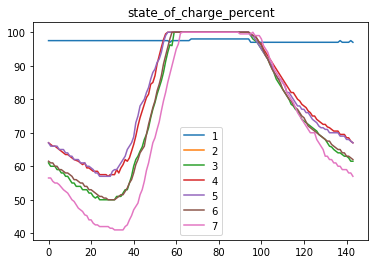

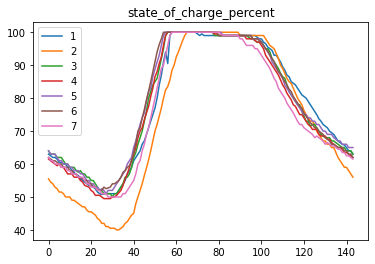

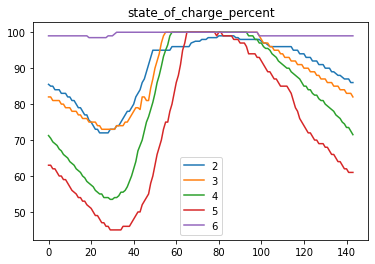

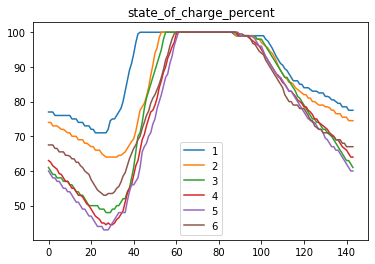

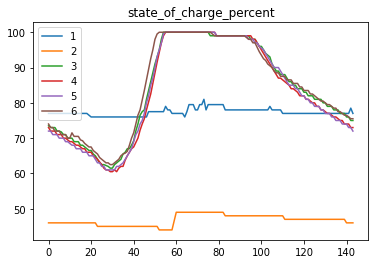

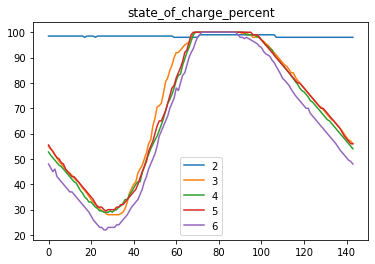

In [25]:
df = df.reset_index().set_index('timestamp')

n = 10
randoms_ids = np.random.choice(df.battery_id.unique(), n)

for bat_id in randoms_ids:
    subset = df[df['battery_id'] == bat_id].copy()
    subset['month'] = subset.index.month
    months = subset.month.unique()
    months.sort()

    '''     plt.figure()
    plt.title('power_out')
    for mo in months:
        subset_month = subset[subset['month'] == mo]
        daily_median_profiles = subset_month.groupby(['battery_id','hour','minutes']).median()
        plt.plot(daily_median_profiles['power_out'].values, label = mo)
        plt.legend() '''

    plt.figure()
    plt.title('state_of_charge_percent')
    for mo in months:
        subset_month = subset[subset['month'] == mo]
        daily_median_profiles = subset_month.groupby(['battery_id','hour','minutes']).median()
        plt.plot(daily_median_profiles['state_of_charge_percent'].values, label = mo)
        plt.legend()

# legacy

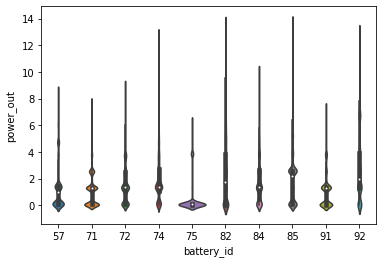

In [31]:
n = 10
randoms_ids = np.random.choice(df.battery_id.unique(), n)

subset = df[df['battery_id'].isin(randoms_ids)]

sns.violinplot(data = subset, x = 'battery_id', y="power_out")

weekly_median_profiles = subset.groupby(['battery_id','day_n','hour','minutes']).median()
daily_median_profiles = subset.groupby(['battery_id','hour','minutes']).median()

<AxesSubplot:xlabel='hour,minutes'>

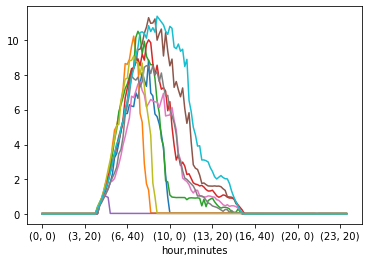

<Figure size 432x288 with 0 Axes>

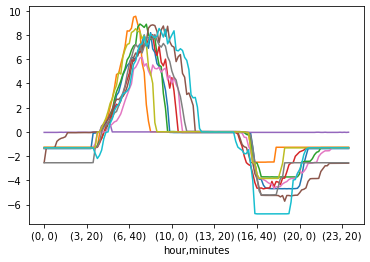

<Figure size 432x288 with 0 Axes>

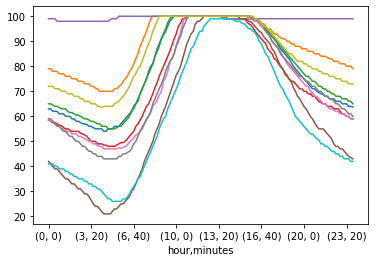

In [38]:
daily_median_profiles['power_in'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

plt.figure()

daily_median_profiles['net_power_battery'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

plt.figure()

daily_median_profiles['state_of_charge_percent'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

<AxesSubplot:>

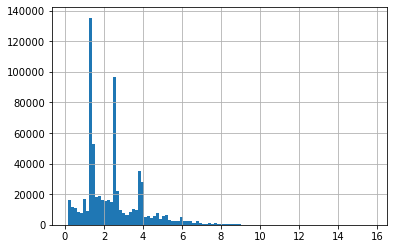

In [43]:
df[df['current_out'] > 2e-2].power_out.hist(bins = 100)

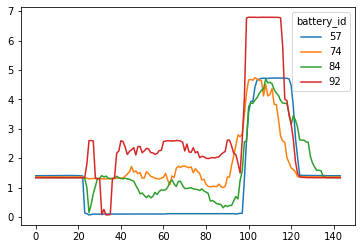

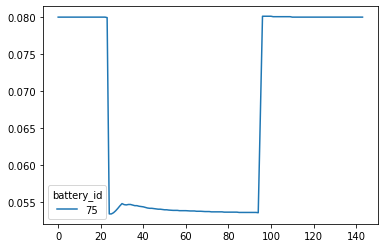

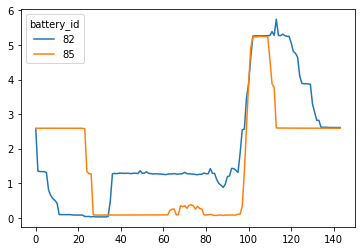

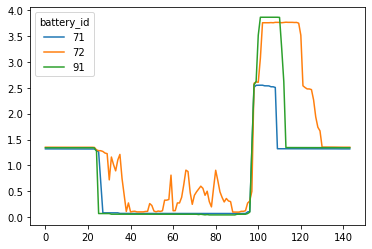

In [44]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 4
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10)
power_out_shape = daily_median_profiles['power_out'].unstack(level = 0).sort_index().reset_index(drop=True).transpose()
classes = model.fit_predict(power_out_shape)
power_out_shape['classes'] = classes
power_out_shape = power_out_shape.reset_index().set_index(['classes','battery_id'])
for k in range(n_clusters):
    df_plot = power_out_shape.loc[k].transpose()
    df_plot.plot()

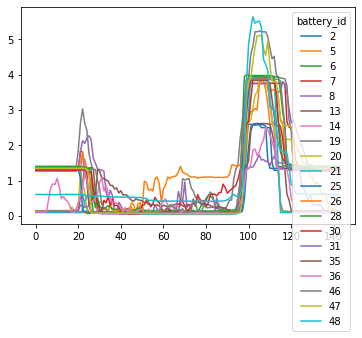

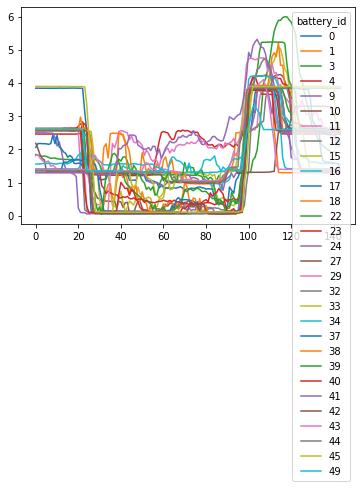

In [ ]:
n_clusters = 2
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10)
power_out_shape = median_profiles['power_out'].unstack(level = 0).sort_index().reset_index(drop=True).transpose()
classes = model.fit_predict(power_out_shape)
power_out_shape['classes'] = classes
power_out_shape = power_out_shape.reset_index().set_index(['classes','battery_id'])
for k in range(n_clusters):
    df_plot = power_out_shape.loc[k].transpose()
    df_plot.plot()

In [ ]:
df_charging = df[df['current'] < -2e-1]

In [ ]:
import seaborn as sns

<AxesSubplot:xlabel='battery_id', ylabel='current_in'>

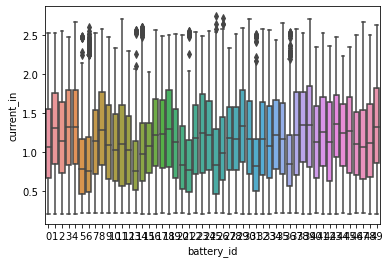

In [ ]:
sns.boxplot(data = df_charging, x = 'battery_id', y = 'current_in')